# Decay Curves

Fluorescence decays are handeled by `IMP.bff.DecayCurve` objects. The use of `IMP.bff.DecayCurve` instances is outlined in the introduction. 

Introduction:
 * reading / attributes
 * computing with curves 
 * shifting curves

Applications: 
 1. Integrating measurements
 1. Time-resolved anistropy
 2. FRET induced donor decay


In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import IMP
import IMP.bff

## Introduction

## Reading

In [3]:
dt = 0.0141 # time resolution (bin width of decay histogram)

fns = {
    "lintable": IMP.bff.get_example_path("spectroscopy/hgbp1_titration/whitelight.txt"),
    "irf": IMP.bff.get_example_path("spectroscopy/hgbp1_titration/Prompt.txt"),
    "donor": IMP.bff.get_example_path("spectroscopy/hgbp1_titration/c0.txt")
}

data = dict()
for key in fns:
    df = pd.read_csv(fns[key], skiprows=6, sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])


In [4]:
# Read the FRET data
path = IMP.bff.get_example_path("spectroscopy/hgbp1_titration/")
data_fret = dict()
for fn in pathlib.Path(path).glob("c*.txt"):
    df = pd.read_csv(fn, skiprows=6, sep='\t')
    data_fret[fn.stem] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

## Attributes


(1, 200000)

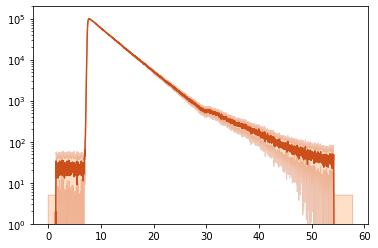

In [116]:
c = data_fret["c0"]

# Aquisition time
c.get_acquisition_time()
c.set_acquisition_time(1800.0)

# Time shift
c.set_shift(1.0)
c.get_shift()

# Time-axis 
c.x

# Counts
c.y

# Error (in y)
c.ey

#plt.semilogy(c.x, c.y, 'b-')
a = 5.0 # factor to make error bands better visible
plt.semilogy(c.x, c.y, '-', color='#CC4F1B')
plt.fill_between(c.x, c.y-a*c.ey, c.y+a*c.ey,
    alpha=0.3, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.ylim(1, 200000)

## Operations
Only addition and multiplication (subtraction and divusion via inverse)

### Addition

In [6]:
c1 = data_fret['c1']
c2 = data_fret['c2']
s12 = c1 + c2

Error gets handeled

/tmp/ipykernel_22374/3040374513.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(s12.ey / s12.y, label="s12")
/opt/tljh/user/envs/dev/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/tljh/user/envs/dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/tmp/ipykernel_22374/3040374513.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(c1.ey / c1.y, label="c1")
/tmp/ipykernel_22374/3040374513.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(c2.ey / c2.y, label="c2")


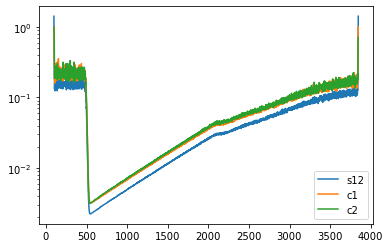

In [7]:
plt.semilogy(s12.ey / s12.y, label="s12")
plt.semilogy(c1.ey / c1.y, label="c1")
plt.semilogy(c2.ey / c2.y, label="c2")
plt.legend()
plt.show()

### Subtraction


In [8]:
c1 = data_fret['c1']
c2 = data_fret['c2']
d12 = c1 - c2

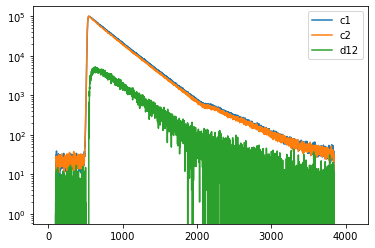

In [9]:
plt.semilogy(c1.y, label="c1")
plt.semilogy(c2.y, label="c2")
plt.semilogy(d12.y, label="d12")
plt.legend()
plt.show()

### Multiplication



In [10]:
c1 = data_fret['c1']
c2 = data_fret['c2']
m12 = c1 * c2

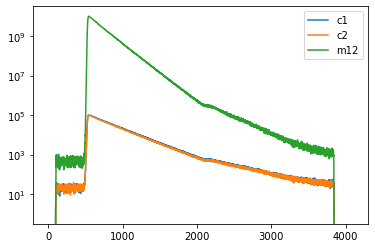

In [11]:
plt.semilogy(c1.y, label="c1")
plt.semilogy(c2.y, label="c2")
plt.semilogy(m12.y, label="m12")
plt.legend()
plt.show()

### Division

In [12]:
c1 = data_fret['c1']
c2 = data_fret['c2']
d12 = c1 / c2

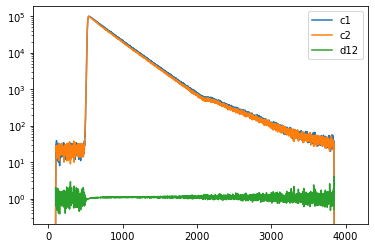

In [13]:
plt.semilogy(c1.y, label="c1")
plt.semilogy(c2.y, label="c2")
plt.semilogy(d12.y, label="d12")
plt.legend()
plt.show()

### Shifting

Fluorescence decays can be shifted with respect to each other. Shifts of `DecayCurve` objects can be modified by the shift operator `<<`. Even though the `<<` returns a `DecayCurve` object operations are inplace, i.e., the original object gets modified when the shift operator is applied. Thus, decay curves store the original (initial) data that was used to create a `DecayCurve` object as private attribute to preserve the original data.

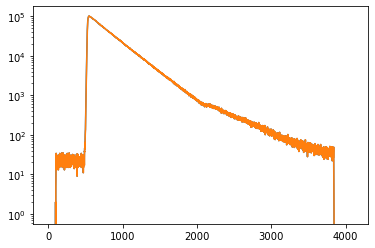

[1.41000e-02 2.82000e-02 4.23000e-02 ... 5.77254e+01 5.77395e+01
 5.77536e+01]
[0. 0. 0. ... 0. 0. 0.]


In [14]:
c = data_fret["c0"]
plt.semilogy(c.y)
c << 0
plt.semilogy(c.y)
plt.show()
print(c.x)
print(c.y)

## Applications

### FRET induced donor decay

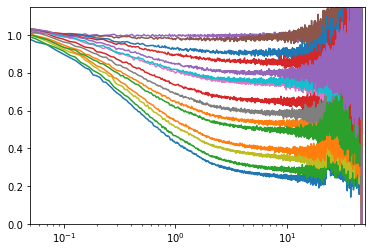

In [34]:
donor = data_fret["c0"]
donor << 0.0

# smooth donor -> first make a copy
donor_smooth = IMP.bff.DecayCurve(donor.x, donor.y)
# Simple moving average
sma_kw = {
    "start": 0,
    "stop": 4096,
    "n_window": 3,
    "normalize": False
}
donor_smooth.apply_simple_moving_average(**sma_kw)

for k in data_fret:
    fret = data_fret[k]
    et = fret / donor_smooth
    # Shift decays (irf) to approx t=0
    et = et << 540.0
    plt.semilogx(et.x, et.y, label=k)
plt.ylim((-0.0, 1.15))
plt.xlim((0.05, 50.0))
plt.show()

### Anisotropy

In [49]:
# Read anisotropy data

dt = 0.0141 # time resolution (bin width of decay histogram)
fns = {
    "vv": IMP.bff.get_example_path("spectroscopy/anisotropy/GFP/VV.dat"),
    "vh": IMP.bff.get_example_path("spectroscopy/anisotropy/GFP/VH.dat"),
    "vm": IMP.bff.get_example_path("spectroscopy/anisotropy//GFP/VM.dat"),
    "irf": IMP.bff.get_example_path("spectroscopy/anisotropy//GFP/IRF.dat")
}
data = dict()
for key in fns:
    df = pd.read_csv(fns[key], sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Time [ns]'], y=df['Intensity [Cnts.]'])

vv
vh
vm
irf


In [126]:
g_factor = 0.7
irf = data['irf']
vv = data['vv']
vh_c = data['vh'] * g_factor
D = vv - vh_c
S = vv + vh_c * 2.0
r = D / S

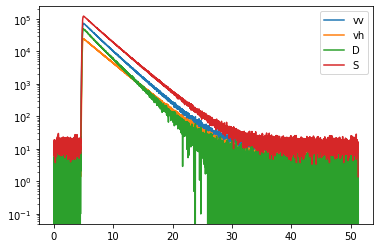

(0.0, 25.0)

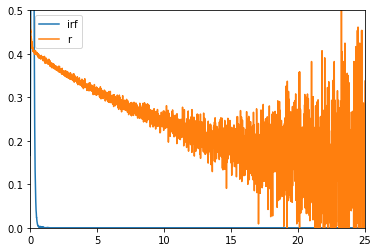

In [137]:
plt.semilogy(vv.x, vv.y, label="vv")
plt.semilogy(vh_c.x, vh_c.y, label="vh")
plt.semilogy(D.x, D.y, label="D")
plt.semilogy(S.x, S.y, label="S")
plt.legend()
plt.show()

shift = 580.0
r << shift
irf << shift

irf_y = irf.y
irf_y /= max(irf_y) * 0.4 # scale IRF for plot
plt.plot(irf.x, irf_y, label="irf")
plt.plot(r.x, r.y, label="r")
plt.legend()
plt.ylim(0, 0.5)
plt.xlim(0, 25)

Due to the division by the sum (a noisy curve) the noise in r(t) is very high. Again average to reduce noise (like for $\epsilon(t)$).